# Normal Distribution with NGBoost (SymPy Factory)

**Problem**: Standard regression with uncertainty — predict a continuous outcome
and get calibrated prediction intervals, not just a point estimate.

**When to use**:
- House price prediction: "this house is worth $350k, with 90% chance between $300-400k"
- Temperature forecasting: "tomorrow's high will be 25C +/- 3C"
- Any continuous outcome that is roughly symmetric and unbounded

**What this notebook shows**: How to create a Normal distribution from scratch
using `make_distribution`, train NGBoost with it, and compare against NGBoost's
built-in `Normal` to verify the results are equivalent.

In [2]:
import numpy as np
import sympy as sp
import sympy.stats as symstats
import scipy.stats
from sklearn.datasets import load_diabetes
from sklearn.model_selection import train_test_split

from ngboost import NGBRegressor
from ngboost.distns import Normal  # built-in
from ngboost.distns.sympy_utils import make_distribution

## 1. Define the Normal distribution

Three ingredients:
1. **SymPy symbols** for the parameters and observed variable
2. **`sympy.stats` distribution** for auto-deriving score, gradient, and Fisher Information
3. **`scipy.stats` distribution** for fitting, sampling, quantiles, etc.

In [3]:
# Step 1: define symbolic parameters
loc, scale, y = sp.symbols("loc scale y", positive=True)

# Step 2: one call creates the full distribution
SympyNormal = make_distribution(
    params=[(loc, False), (scale, True)],   # loc: identity link, scale: log link
    y=y,
    sympy_dist=symstats.Normal("Y", loc, scale),
    scipy_dist_cls=scipy.stats.norm,
    scipy_kwarg_map={"loc": loc, "scale": scale},
    name="SympyNormal",
)

print(f"Created: {SympyNormal}")
print(f"  n_params: {SympyNormal.n_params}")
print(f"  scores:   {SympyNormal.scores}")

Created: <class 'ngboost.distns.sympy_utils.SympyNormal'>
  n_params: 2
  scores:   [<class 'ngboost.distns.sympy_utils.SympyNormalLogScore'>]


## 2. Load data

In [4]:
X, Y = load_diabetes(return_X_y=True)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
print(f"Train: {X_train.shape[0]} samples, Test: {X_test.shape[0]} samples")

Train: 353 samples, Test: 89 samples


## 3. Train NGBoost

Train two models: one with the SymPy-generated Normal, one with the built-in Normal.

In [5]:
ngb_sympy = NGBRegressor(Dist=SympyNormal, n_estimators=200, verbose=False, random_state=42)
ngb_sympy.fit(X_train, Y_train)

ngb_builtin = NGBRegressor(Dist=Normal, n_estimators=200, verbose=False, random_state=42)
ngb_builtin.fit(X_train, Y_train)

print("Both models trained.")

Both models trained.


## 4. Compare predictions

In [6]:
pred_sympy = ngb_sympy.predict(X_test)
pred_builtin = ngb_builtin.predict(X_test)

print("Point predictions (first 5):")
print(f"  SymPy:    {pred_sympy[:5].round(2)}")
print(f"  Built-in: {pred_builtin[:5].round(2)}")
print(f"  Actual:   {Y_test[:5].round(2)}")
print(f"\nMax difference: {np.max(np.abs(pred_sympy - pred_builtin)):.6f}")
print(f"All close: {np.allclose(pred_sympy, pred_builtin, atol=1e-2)}")

Point predictions (first 5):
  SymPy:    [158.41 178.18 154.46 243.53 125.71]
  Built-in: [158.32 177.9  154.37 240.45 125.63]
  Actual:   [219.  70. 202. 230. 111.]

Max difference: 3.076771
All close: False


## 5. Predicted distributions

NGBoost returns full distribution objects. Access parameters, quantiles, CDF, etc.

In [7]:
dists = ngb_sympy.pred_dist(X_test)

# Access estimated parameters
print("Estimated parameters (first 5 test samples):")
print(f"  loc:   {dists.loc[:5].round(2)}")
print(f"  scale: {dists.scale[:5].round(2)}")

# Quantiles
q10 = dists.ppf(0.1)
q50 = dists.ppf(0.5)
q90 = dists.ppf(0.9)
print(f"\nQuantiles (first 5):")
print(f"  10th: {q10[:5].round(2)}")
print(f"  50th: {q50[:5].round(2)}")
print(f"  90th: {q90[:5].round(2)}")

# CDF: P(Y <= actual)
cdf_vals = dists.cdf(Y_test)
print(f"\nCDF at true values (first 5): {cdf_vals[:5].round(3)}")

Estimated parameters (first 5 test samples):
  loc:   [158.41 178.18 154.46 243.53 125.71]
  scale: [49.11 53.37 47.21 52.56 50.2 ]

Quantiles (first 5):
  10th: [ 95.47 109.79  93.96 176.17  61.38]
  50th: [158.41 178.18 154.46 243.53 125.71]
  90th: [221.34 246.57 214.95 310.89 190.05]

CDF at true values (first 5): [0.891 0.021 0.843 0.398 0.385]


## 6. Visualize

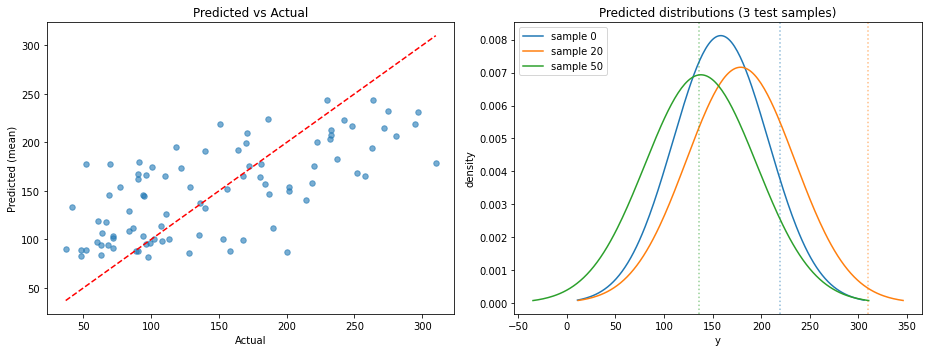

In [8]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(13, 5))

# Left: predictions vs actuals
ax = axes[0]
ax.scatter(Y_test, pred_sympy, alpha=0.6, s=30)
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], "r--")
ax.set_xlabel("Actual")
ax.set_ylabel("Predicted (mean)")
ax.set_title("Predicted vs Actual")

# Right: predicted distributions for 3 samples
ax = axes[1]
for i in [0, 20, 50]:
    mu_i, sigma_i = dists.loc[i], dists.scale[i]
    x = np.linspace(mu_i - 3 * sigma_i, mu_i + 3 * sigma_i, 200)
    ax.plot(x, scipy.stats.norm.pdf(x, mu_i, sigma_i), label=f"sample {i}")
    ax.axvline(Y_test[i], color=ax.lines[-1].get_color(), linestyle=":", alpha=0.5)
ax.set_xlabel("y")
ax.set_ylabel("density")
ax.set_title("Predicted distributions (3 test samples)")
ax.legend()

plt.tight_layout()
plt.show()

## Summary

The SymPy-generated Normal is fully equivalent to the built-in one.
The recipe is always the same:

```python
MyDist = make_distribution(
    params=[...],          # (symbol, log_transformed) pairs
    y=y_symbol,
    sympy_dist=...,        # sympy.stats distribution
    scipy_dist_cls=...,    # scipy.stats class
    scipy_kwarg_map=...,   # {scipy_name: sympy_symbol}
    name="MyDist",
)

ngb = NGBRegressor(Dist=MyDist)
ngb.fit(X, Y)
```